In [10]:
from utils.FaceSketchDataset import FaceSketchDataset
from torch.utils.data import DataLoader
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
from models.unet import UNet
from models.diffusion import Diffusion
import torch    
import tqdm.notebook as tqdm  
from torchvision.utils import save_image
from utils.Training_loop import TrainingLoop
from utils.DataAugmentation import *
import math

Dataset creation

In [2]:
DATA_PATH = r"C:\Users\mikol\OneDrive\Pulpit\Data\Face_Sketch"
dataset = FaceSketchDataset(root_dir=DATA_PATH)
print("Base:", len(dataset))

Base: 100


Data augmentation

In [3]:
# deterministic flips / rotations
transform_list = [no_op_transform, horizontal_flip, rotate_90, rotate_180]
train_set = ExpandDataset(dataset, transform_list)
print("Expanded:", len(train_set))

Expanded: 400


In [4]:
dataloader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=4, drop_last=True)

In [5]:
for sketch, photo in dataloader:
    print("Sketch:", sketch.shape, "| Photo:", photo.shape)
    break

Sketch: torch.Size([8, 1, 256, 256]) | Photo: torch.Size([8, 3, 256, 256])


In [6]:
for sketch_batch, photo_batch in dataloader:
    print("Sketch batch:", sketch_batch.shape)  # (Batch size, 1, 256, 256)
    print("Photo batch:", photo_batch.shape)      # (Batch size, 3, 256, 256)
    break

Sketch batch: torch.Size([8, 1, 256, 256])
Photo batch: torch.Size([8, 3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].


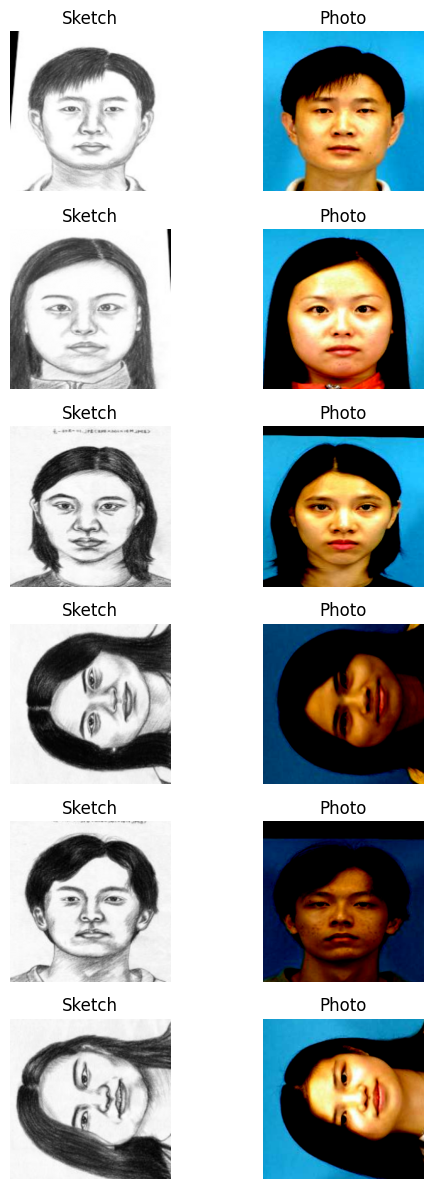

In [7]:
from utils.visualization import show_sketch_photo_batch
show_sketch_photo_batch(sketch_batch, photo_batch)

In [8]:
print("Sketch min/max:", sketch_batch.min().item(), sketch_batch.max().item())
print("Photo min/max:", photo_batch.min().item(), photo_batch.max().item())

Sketch min/max: -1.0 1.0
Photo min/max: -1.0 1.0


Model use

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [11]:
model     = UNet(n_channels=4, n_classes=3).to(device)
diffusion = Diffusion(timesteps=200, device=device)          # 200‑step schedule
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
target_steps   = 50_000
epochs_needed  = math.ceil(target_steps / len(dataloader))
trainer        = TrainingLoop(model, diffusion, dataloader,
                              optimizer, device=device, epochs=epochs_needed)
trainer.train()                                      

In [ ]:
torch.save(trainer.ema_model.state_dict(), "diffusion_model_ema.pth")

Inference: Use the trained model to convert a sketch into a photo via reverse diffusion

In [ ]:
# Prepare a conditioning sketch
sketch, _ = dataset[0]                       # normalised to [-1,1]
sketch = sketch.unsqueeze(0).to(device)      # (1,1,256,256)

In [ ]:
model.load_state_dict(torch.load("diffusion_model.pth", map_location=device))
model.eval()

In [ ]:
# reverse diffusion sampling
with torch.no_grad():
    # Start from pure random noise, batch size = 1
    sample_img = torch.randn((1, 3, 256, 256), device=device)
    intermediate_results = []
    record_interval = max(1, diffusion.timesteps // 10)  # Record roughly 10 snapshots

    for t in tqdm.tqdm(reversed(range(diffusion.timesteps)), desc="Reverse Diffusion", unit="step", leave=False):
        t_tensor = torch.tensor([t], device=device)
        # Create conditional input by concatenating the sketch with the current sample image
        cond_input = torch.cat([sketch, sample_img], dim=1)  # shape: (1, 4, 256, 256)
        predicted_noise = model(cond_input, t_tensor)
        
        beta_t = diffusion.betas[t]
        alpha_t = diffusion.alphas[t]
        alpha_hat_t = diffusion.alpha_hat[t]
        noise = torch.randn_like(sample_img) if t > 0 else 0
        
        # Simplified reverse diffusion update (DDPM-esque)
        sample_img = (1 / torch.sqrt(alpha_t)) * (sample_img - (beta_t / torch.sqrt(1 - alpha_hat_t)) * predicted_noise) \
                     + torch.sqrt(beta_t) * noise
        
        # Record snapshots at intervals
        if t % record_interval == 0 or t == 0:
            intermediate_results.append((t, sample_img.clone().cpu()))

In [ ]:
# Visualize the intermediate snapshots to see the evolution of the image
n_results = len(intermediate_results)
fig, axes = plt.subplots(1, n_results, figsize=(3 * n_results, 3))
if n_results == 1:
    axes = [axes]
for ax, (t_val, img_tensor) in zip(axes, intermediate_results):
    img_np = img_tensor.squeeze(0).permute(1, 2, 0).clamp(0, 1).numpy() # Convert tensor to numpy format (H x W x C) and clamp values to [0, 1]
    ax.imshow(img_np)
    ax.set_title(f"T = {t_val}")
    ax.axis("off")
plt.tight_layout()
plt.show()